<a href="https://colab.research.google.com/github/ayulockin/Explore-NFNet/blob/main/Train_Basline_Without_Gradient_Clipping_And_LR%3D0_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧰 Setups, Installations and Imports

In [ ]:
%%capture
!pip install wandb --upgrade
!pip install albumentations

In [ ]:
!git clone https://github.com/ayulockin/Explore-NFNet

Cloning into 'Explore-NFNet'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 51 (delta 18), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds

import sys
sys.path.append("Explore-NFNet")
import os
import cv2
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

# Imports from the cloned repository
from models.resnet import resnet_v1 
from models.mini_vgg import get_mini_vgg

# Augmentation related imports
import albumentations as A

# Seed everything for reproducibility
def seed_everything():
    # Set the random seeds
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

# Avoid TensorFlow to allocate all the GPU at once. 
# Ref: https://www.tensorflow.org/guide/gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.4.1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
DATASET_NAME = 'cifar10'
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = 10
SHUFFLE_BUFFER = 1024
BATCH_SIZE = 256
EPOCHS = 100

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(f'Global batch size is: {BATCH_SIZE}')

Global batch size is: 256


# ⛄ Download and Prepare Dataset

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load(name=DATASET_NAME, 
                          split=["train[:85%]", "train[85%:]", "test"], 
                          with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteH2K1CW/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteH2K1CW/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
@tf.function
def preprocess(image, label):
    # preprocess image
    image = tf.cast(image, tf.float32)
    image = image/255.0

    return image, label

# Define the augmentation policies. Note that they are applied sequentially with some probability p.
transforms = A.Compose([
                A.HorizontalFlip(p=0.7),
                A.Rotate(limit=30, p=0.7)
        ])

# Apply augmentation policies.
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]

    return aug_img

@tf.function
def apply_augmentation(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    
    return aug_img, label

train_ds = (
    train_ds
    .shuffle(SHUFFLE_BUFFER)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

(256, 32, 32, 3) (256,)


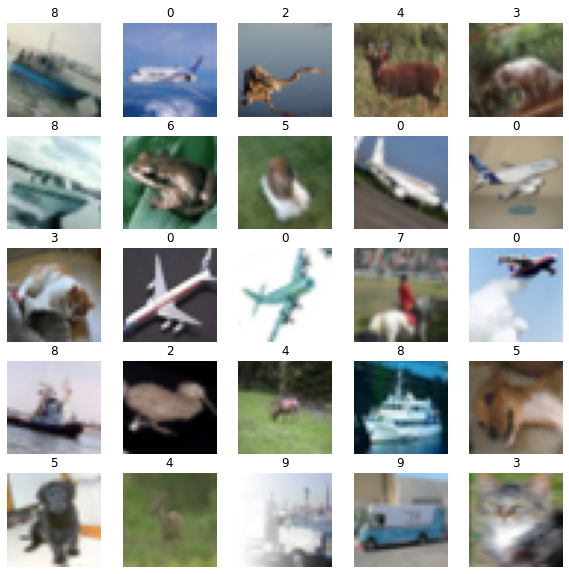

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      # plt.title(f'{np.argmax(label_batch[n].numpy())}')
      plt.title(f'{label_batch[n].numpy()}')
      plt.axis('off')
  
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

print(image_batch.shape, label_batch.shape)

# 🐤 Model

In [ ]:
class ResNetModel(tf.keras.Model):
    def __init__(self, resnet):
        super(ResNetModel, self).__init__()
        self.resnet = resnet
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.resnet(images)
            loss = self.compiled_loss(labels, predictions)

        trainable_params = self.resnet.trainable_variables
        gradients = tape.gradient(loss, trainable_params)  
        gradients_clipped =  [tf.clip_by_norm(g, 0.01) for g in gradients] # clippling threshold = 0.01

        self.optimizer.apply_gradients(zip(gradients_clipped, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.resnet(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def save_weights(self, filepath):
        self.resnet.save_weights(filepath=filepath, save_format="tf")

    def call(self, inputs, *args, **kwargs):
        return self.resnet(inputs)

tf.keras.backend.clear_session()
test_model = ResNetModel(resnet_v1((IMG_HEIGHT, IMG_WIDTH, 3), 20, num_classes=NUM_CLASSES, use_bn=False))
test_model.build((1, IMG_HEIGHT, IMG_WIDTH, 3))
test_model.summary()
print(f"Total learnable parameters: {test_model.count_params()/1e6} M")

Model: "res_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 10)                271754    
Total params: 271,754
Trainable params: 271,722
Non-trainable params: 32
_________________________________________________________________
Total learnable parameters: 0.271754 M


# 📲 Callbacks

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True
)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5,
    patience=3, verbose=1
)

# 🚋 Train with W&B

In [ ]:
tf.keras.backend.clear_session()
# Intialize model
model = ResNetModel(resnet_v1((IMG_HEIGHT, IMG_WIDTH, 3), 20, num_classes=NUM_CLASSES, use_bn=False))
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, 'sparse_categorical_crossentropy', metrics=['acc'])

# Intialize W&B run
run = wandb.init(project='nfnet', job_type='train-grad-clip')

# Train model
model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=val_ds,
          callbacks=[WandbCallback(),
                     reducelronplateau,
                     earlystopper])  

# Evaluate model on test set
loss, acc = model.evaluate(test_ds)
wandb.log({'Test Accuracy': round(acc, 3)})

# Close W&B run
run.finish()

Epoch 1/100
  6/167 [>.............................] - ETA: 11s - loss: 58.2011 - acc: 0.0920WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0290s vs `on_train_batch_end` time: 0.0418s). Check your callbacks.


167/167 [==============================] - 13s 66ms/step - loss: 7.9775 - acc: 0.1278 - val_loss: 1.9481 - val_acc: 0.2517


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/100
167/167 [==============================] - 12s 69ms/step - loss: 2.0070 - acc: 0.2399 - val_loss: 2.1884 - val_acc: 0.2549
Epoch 3/100
167/167 [==============================] - 12s 69ms/step - loss: 1.9169 - acc: 0.2793 - val_loss: 1.8189 - val_acc: 0.3077
Epoch 4/100
167/167 [==============================] - 12s 69ms/step - loss: 1.8536 - acc: 0.3012 - val_loss: 1.7263 - val_acc: 0.3428
Epoch 5/100
167/167 [==============================] - 12s 69ms/step - loss: 1.7534 - acc: 0.3358 - val_loss: 1.6977 - val_acc: 0.3503
Epoch 6/100
167/167 [==============================] - 12s 69ms/step - loss: 1.7452 - acc: 0.3510 - val_loss: 2.1337 - val_acc: 0.3144
Epoch 7/100
167/167 [==============================] - 11s 68ms/step - loss: 1.7181 - acc: 0.3694 - val_loss: 1.5968 - val_acc: 0.3964
Epoch 8/100
167/167 [==============================] - 12s 69ms/step - loss: 1.6367 - acc: 0.3876 - val_loss: 1.5647 - val_acc: 0.4087
Epoch 9/100
167/167 [==============================] - 

epoch,99
loss,1.00752
acc,0.6448
val_loss,1.0236
val_acc,0.63827
_runtime,1158
_timestamp,1615216449
_step,100
best_val_loss,1.02228
best_epoch,91
Test Accuracy,0.644


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,▁▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████
val_loss,▇▆█▄▄▄▃▃▄▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇█▇████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁
